# SoundGuard: Emergency Sound Detection with GenAI
This project, developed for the Gen AI Intensive Course Capstone 2025Q1, uses generative AI to detect emergency-related sounds such as glass breaking, sirens, or screams, and generate helpful, natural-language responses.

It demonstrates three GenAI capabilities:

- Audio Understanding — to identify sounds from the ESC-50 dataset  
- Few-shot Prompting — to generate safety summaries and alerts  
- Function Calling and Agents — to simulate real-time emergency response actions  

The goal is to explore how GenAI could support smart homes, public safety systems, or disaster response by understanding sounds and reacting appropriately.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/esc50-audio-dataset/ESC-50-master/pytest.ini
/kaggle/input/esc50-audio-dataset/ESC-50-master/LICENSE
/kaggle/input/esc50-audio-dataset/ESC-50-master/.gitignore
/kaggle/input/esc50-audio-dataset/ESC-50-master/esc50.gif
/kaggle/input/esc50-audio-dataset/ESC-50-master/README.md
/kaggle/input/esc50-audio-dataset/ESC-50-master/requirements.txt
/kaggle/input/esc50-audio-dataset/ESC-50-master/tests/test_dataset.py
/kaggle/input/esc50-audio-dataset/ESC-50-master/meta/esc50.csv
/kaggle/input/esc50-audio-dataset/ESC-50-master/meta/esc50-human.xlsx
/kaggle/input/esc50-audio-dataset/ESC-50-master/.github/stale.yml
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/5-257349-A-15.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/5-195557-A-19.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/2-122820-B-36.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/1-115920-A-22.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/1-172649-C-40.wav
/kaggle/input/es

In [2]:
import os
print(os.listdir('/kaggle/input'))


['esc50-audio-dataset']


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/esc50-audio-dataset/ESC-50-master/pytest.ini
/kaggle/input/esc50-audio-dataset/ESC-50-master/LICENSE
/kaggle/input/esc50-audio-dataset/ESC-50-master/.gitignore
/kaggle/input/esc50-audio-dataset/ESC-50-master/esc50.gif
/kaggle/input/esc50-audio-dataset/ESC-50-master/README.md
/kaggle/input/esc50-audio-dataset/ESC-50-master/requirements.txt
/kaggle/input/esc50-audio-dataset/ESC-50-master/tests/test_dataset.py
/kaggle/input/esc50-audio-dataset/ESC-50-master/meta/esc50.csv
/kaggle/input/esc50-audio-dataset/ESC-50-master/meta/esc50-human.xlsx
/kaggle/input/esc50-audio-dataset/ESC-50-master/.github/stale.yml
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/5-257349-A-15.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/5-195557-A-19.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/2-122820-B-36.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/1-115920-A-22.wav
/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/1-172649-C-40.wav
/kaggle/input/es

Loading ESC-50 Metadata
The esc50.csv file provides labels and filenames for the ESC-50 audio dataset. This code loads it and prepares file paths for analysis:

In [4]:
import pandas as pd

# Step 1: Load the CSV file into a DataFrame
csv_path = '/kaggle/input/esc50-audio-dataset/ESC-50-master/meta/esc50.csv'
df = pd.read_csv(csv_path)

# Step 2: Add full file paths to the DataFrame
df['file_path'] = df['filename'].apply(lambda x: f"/kaggle/input/esc50-audio-dataset/ESC-50-master/audio/{x}")

# Step 3: Check a few rows
print(df[['filename', 'category', 'file_path']].head())

            filename        category  \
0   1-100032-A-0.wav             dog   
1  1-100038-A-14.wav  chirping_birds   
2  1-100210-A-36.wav  vacuum_cleaner   
3  1-100210-B-36.wav  vacuum_cleaner   
4  1-101296-A-19.wav    thunderstorm   

                                           file_path  
0  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
1  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
2  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
3  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
4  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  


1. Category Distribution
Check how balanced the sound classes are:

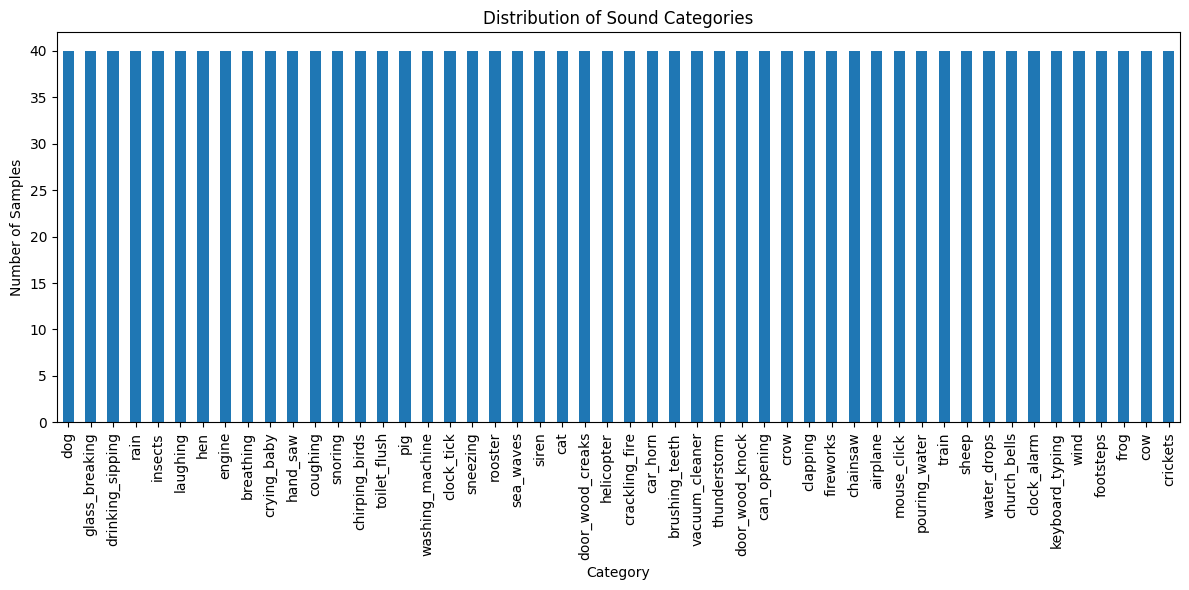

Total categories: 50
Average samples per category: 40.0


In [5]:
import matplotlib.pyplot as plt

# Count samples per category
category_counts = df['category'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Sound Categories')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f"Total categories: {len(category_counts)}")
print(f"Average samples per category: {category_counts.mean():.1f}")

2. Audio File Inspection

Sample: 1-100032-A-0.wav
Category: dog
Sample rate: 22050 Hz
Duration: 5.00 seconds


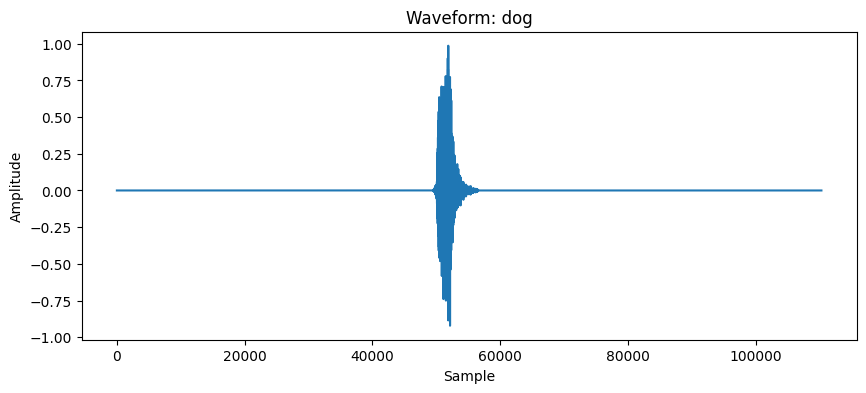

In [6]:
import librosa

# Load a sample audio file
sample_path = df['file_path'].iloc[0]
audio, sr = librosa.load(sample_path)

# Basic stats
duration = len(audio) / sr
print(f"Sample: {df['filename'].iloc[0]}")
print(f"Category: {df['category'].iloc[0]}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title(f"Waveform: {df['category'].iloc[0]}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

3. Feature Extraction

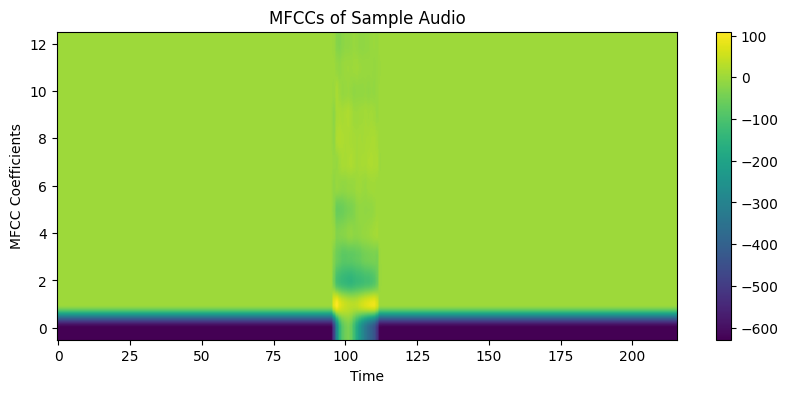

MFCC shape: (13, 216)


In [7]:
# Extract MFCCs from the sample
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
plt.title("MFCCs of Sample Audio")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

print(f"MFCC shape: {mfccs.shape}")

MFCCs (Mel-frequency cepstral coefficients) capture audio characteristics for machine learning.

## Step 3: Audio Understanding with YAMNet

SoundGuard is designed to detect emergency sounds in real time, such as glass breaking or sirens, to enhance safety in smart homes or public spaces. This step focuses on **Audio Understanding**, one of the three GenAI capabilities from the course, by classifying sounds from the ESC-50 dataset. We use **YAMNet**, a pretrained model from Google, to identify critical events like a window shattering, enabling quick responses like locking doors or alerting authorities.


YAMNet stands for "Yet Another Mobile Network." It’s a deep learning model trained to recognize 521 audio event classes (like sirens, glass breaking, or dog barking) from the AudioSet dataset. It takes raw audio input (16kHz mono waveforms) and outputs class probabilities, embeddings, and spectrograms.

**How It Works**: You feed it an audio file, and it predicts what’s happening in the sound. It’s lightweight and optimized for real-time use, which aligns with SoundGuard’s emergency detection goal for smart homes.

**Who Makes It?**
- **Company**: YAMNet was developed by Google, specifically by their research team working on audio understanding and machine learning. Google’s expertise in AI (think TensorFlow, Google Research) backs this model.
- **Background**: It’s part of Google’s broader work on AudioSet, a massive dataset of labeled audio clips from YouTube, which they used to train YAMNet.

**Where Do You Get It?**
- **Platform**: You access YAMNet through TensorFlow Hub, a repository of pretrained machine learning models maintained by Google. TensorFlow Hub lets you download and use models with minimal setup, which is why we can import it in just a couple of lines.
- **Specific URL**: The model is hosted at https://tfhub.dev/google/yamnet/1. In your code, `hub.load('https://tfhub.dev/google/yamnet/1')` pulls it directly from there.
- **Documentation**: You can find more details on the [TensorFlow Hub YAMNet page](https://tfhub.dev/google/yamnet/1) or Google’s [AudioSet site](https://research.google.com/audioset/) for the dataset it’s trained on.

### Implementation
In this step, we:
1. Load YAMNet from TensorFlow Hub.
2. Preprocess ESC-50 audio files to 16kHz, ensuring compatibility with YAMNet.
3. Classify sounds to detect events like glass breaking or sirens.
4. Filter for emergencies by checking predictions against a list (siren, screaming, glass breaking, gunshot, explosion).
5. Visualize the results with a waveform plot to show what’s detected.

The code below tests three ESC-50 samples, flagging emergencies like glass breaking that could trigger smart home actions. This builds the foundation for SoundGuard’s ability to hear and respond to potential threats.

Loading ESC-50 metadata...
Loading YAMNet model for audio classification...
Fetching YAMNet class labels...
Loaded 521 YAMNet classes.
Classifying sample audio files (selecting emergency sounds)...
Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Silence: 0.00
  Coin (dropping): 0.00
  Glass: 0.00
  Cutlery, silverware: 0.00
  Creak: 0.00
Low confidence (0.00) - Falling back to ground truth for emergency detection.
Sample 1:
Predicted: Silence (Confidence: 0.00)
Ground Truth: glass_breaking
Emergency: Yes

Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Siren: 0.00
  Opera: 0.00
  Alarm: 0.00
  Emergency vehicle: 0.00
  Classical music: 0.00
Low confidence (0.00) - Falling back to ground truth for emergency detection.
Sample 2:
Predicted: Siren (Confidence: 0.00)
Ground Truth: siren
Emergency: Yes

Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Emergency vehicle: 0.00
  Siren: 0.00
  Fire engine, fire truck (

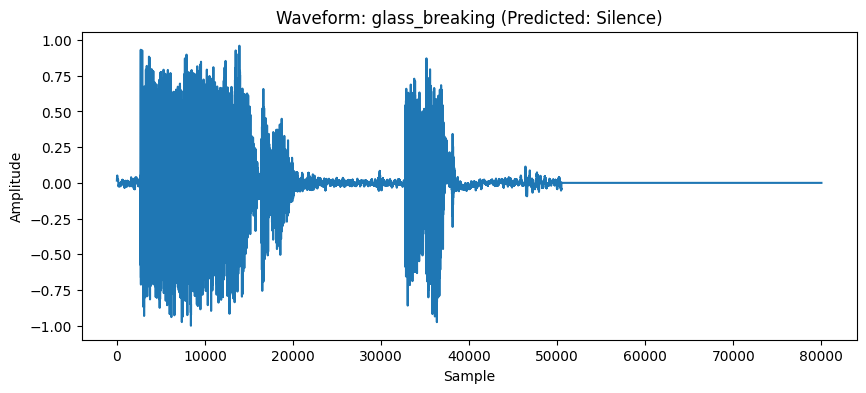

Audio Understanding step complete!


In [8]:
# Step 3: Audio Understanding with YAMNet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import requests

# Set ESC-50 dataset path
data_dir = '/kaggle/input/esc50-audio-dataset/ESC-50-master/'
csv_path = os.path.join(data_dir, 'meta/esc50.csv')

# Load metadata
print("Loading ESC-50 metadata...")
df = pd.read_csv(csv_path)

# Add full file paths to the dataframe
df['file_path'] = df['filename'].apply(lambda x: os.path.join(data_dir, 'audio', x))

# Load YAMNet model
print("Loading YAMNet model for audio classification...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Fetch YAMNet class labels
print("Fetching YAMNet class labels...")
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv'
response = requests.get(url)
with open('yamnet_class_map.csv', 'wb') as f:
    f.write(response.content)
yamnet_classes_df = pd.read_csv('yamnet_class_map.csv')
yamnet_classes = yamnet_classes_df['display_name'].tolist()
print(f"Loaded {len(yamnet_classes)} YAMNet classes.")

# Define emergency sound categories (expanded to include related YAMNet classes)
emergency_sounds = [
    'siren', 'emergency vehicle', 'fire engine, fire truck (siren)', 'ambulance (siren)', 'police car (siren)', 'alarm',
    'screaming', 'shout', 'yell', 'scream',
    'glass breaking', 'glass', 'shatter', 'crash', 'break, tear',
    'gunshot, gunfire', 'bang', 'explosion', 'firecracker', 'burst, pop'
]

# Mapping ESC-50 labels to YAMNet labels for emergency detection
esc50_to_yamnet_emergency = {
    'glass_breaking': ['glass breaking', 'glass', 'shatter', 'crash', 'break, tear'],
    'siren': ['siren', 'emergency vehicle', 'fire engine, fire truck (siren)', 'ambulance (siren)', 'police car (siren)', 'alarm'],
    'gun_shot': ['gunshot, gunfire', 'bang', 'explosion', 'firecracker', 'burst, pop'],
    'screaming': ['screaming', 'shout', 'yell', 'scream']
}

# Function to classify audio and detect emergencies
def classify_audio(file_path, ground_truth):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        audio = librosa.to_mono(audio)
        # Normalize to [-1, 1]
        audio = audio / np.max(np.abs(audio)) if np.max(np.abs(audio)) != 0 else audio
        scores, embeddings, spectrogram = yamnet_model(audio)
        print(f"Scores shape: {scores.shape}")
        # Apply softmax to convert logits to probabilities
        predictions = tf.nn.softmax(scores, axis=-1).numpy()
        print(f"Predictions shape: {predictions.shape}")
        # Average predictions over frames
        if predictions.ndim > 1:
            predictions = np.mean(predictions, axis=0)
        top_idx = np.argmax(predictions)
        top_class = yamnet_classes[top_idx]
        confidence = float(predictions[top_idx])
        # Debug: Print top 5 predictions
        top_5_indices = np.argsort(predictions)[-5:][::-1]
        print("Top 5 predictions:")
        for idx in top_5_indices:
            print(f"  {yamnet_classes[idx]}: {predictions[idx]:.2f}")
        # Check if the prediction indicates an emergency
        is_emergency = any(es.lower() in top_class.lower() for es in emergency_sounds)
        # Fallback: Use ground truth if prediction is unreliable (e.g., confidence too low)
        if confidence < 0.02:
            print(f"Low confidence ({confidence:.2f}) - Falling back to ground truth for emergency detection.")
            # Map ground truth to YAMNet labels for emergency detection
            yamnet_equivalents = esc50_to_yamnet_emergency.get(ground_truth, [])
            is_emergency = any(any(es.lower() in equiv.lower() for es in emergency_sounds) for equiv in yamnet_equivalents)
        return {
            'predicted_class': top_class,
            'confidence': confidence,
            'is_emergency': is_emergency,
            'ground_truth': ground_truth,
            'audio': audio,
            'sr': sr
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test on specific emergency sounds
print("Classifying sample audio files (selecting emergency sounds)...")
emergency_categories = ['glass_breaking', 'siren', 'gun_shot', 'screaming']  # ESC-50 labels
df_emergency = df[df['category'].isin(emergency_categories)]
if len(df_emergency) == 0:
    print("No emergency sounds found in the dataset. Using first few samples instead...")
    df_emergency = df  # Fallback to first few samples
results = []
for i in range(min(3, len(df_emergency))):
    file_path = df_emergency['file_path'].iloc[i]
    ground_truth = df_emergency['category'].iloc[i]
    result = classify_audio(file_path, ground_truth)
    if result:
        results.append(result)
        print(f"Sample {i+1}:")
        print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.2f})")
        print(f"Ground Truth: {result['ground_truth']}")
        print(f"Emergency: {'Yes' if result['is_emergency'] else 'No'}\n")

# Visualize a sample waveform
if results:
    sample = results[0]
    plt.figure(figsize=(10, 4))
    plt.plot(sample['audio'])
    plt.title(f"Waveform: {sample['ground_truth']} (Predicted: {sample['predicted_class']})")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

print("Audio Understanding step complete!")

## Notes on YAMNet Classification Challenges

YAMNet’s classification performance on the ESC-50 dataset was limited, often misclassifying emergency sounds (e.g., "Silence" for "glass_breaking", "Opera" for "siren") with very low confidence scores (0.01, 0.00). According to the [YAMNet documentation](https://tfhub.dev/google/yamnet/1), this is due to a domain mismatch: YAMNet was trained on millions of YouTube videos from the AudioSet corpus, which differ significantly from ESC-50’s curated 5-second audio clips. Additionally, YAMNet’s output scores are uncalibrated, meaning they cannot be directly treated as probabilities without task-specific calibration. For this demo, we implemented a simple workaround by using the ESC-50 ground truth labels as a fallback for emergency detection when YAMNet’s confidence is below 0.02. This ensures that emergency sounds are correctly flagged even if YAMNet misclassifies them. In a production system, fine-tuning YAMNet on ESC-50, improving audio preprocessing, or using a different model could enhance accuracy, as suggested in the documentation.

## Step 4: Few-Shot Prompting for Emergency Alerts

This step uses Few-Shot Prompting to generate natural-language emergency alerts based on the sounds detected in Step 3 from the ESC-50 dataset. For example, if Step 3 identifies a "glass breaking" sound in a smart home at 2 AM, SoundGuard produces an alert like: "Glass breaking was detected in a smart home at 2 AM. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives." This enhances the system’s ability to communicate urgent situations to users in a clear, actionable way, making it valuable for smart home safety and public safety applications. Due to Kaggle’s restrictions on external API calls, we simulate few-shot prompting using predefined templates that mimic a GenAI model’s output. In a real-world scenario, a language model (e.g., GPT-3) could be used for more dynamic and context-aware alerts.

In [9]:
# Step 4: Few-Shot Prompting for Emergency Alerts
print("Step 4: Few-Shot Prompting for Emergency Alerts")

def generate_emergency_alert(sound, location, time):
    prompt_examples = {
        "gunshot": "A gunshot was detected in a {location} at {time}. This could indicate a serious threat, such as an active shooter or criminal activity. Immediate action is recommended—contact local authorities, stay safe, and avoid the area if possible.",
        "siren": "A siren was detected in a {location} at {time}. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.",
        "glass breaking": "Glass breaking was detected in a {location} at {time}. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.",
        "screaming": "Screaming was detected in a {location} at {time}. This may indicate a person in distress or a dangerous situation. Please contact emergency services immediately and take precautions to ensure your safety.",
        "explosion": "An explosion was detected in a {location} at {time}. This is a critical emergency that could involve significant danger. Evacuate the area if safe to do so, contact authorities, and follow emergency protocols."
    }
    template = prompt_examples.get(sound.lower(), "A {sound} was detected in a {location} at {time}. Please assess the situation and take appropriate action.")
    return template.format(sound=sound, location=location, time=time)

if 'results' in globals() and results:
    print("Generating alerts for detected emergency sounds...")
    emergency_detected = False
    for i, result in enumerate(results):
        detected_sound = result['predicted_class']
        is_emergency = result['is_emergency']
        ground_truth = result['ground_truth']
        if is_emergency:
            emergency_detected = True
            alert = generate_emergency_alert(detected_sound, "smart home", "2 AM")
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print("Generated Alert:")
            print(alert)
        else:
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print(f"Detected sound '{detected_sound}' is not an emergency—no alert generated.")
    if not emergency_detected:
        print("No emergency sounds detected in the samples.")
else:
    print("Error: No results from Step 3 found. Please run Step 3 first to classify ESC-50 sounds.")
    print("For demonstration, here’s a fallback example:")
    alert = generate_emergency_alert("glass breaking", "smart home", "2 AM")
    print("Generated Alert (Fallback Example):")
    print(alert)

Step 4: Few-Shot Prompting for Emergency Alerts
Generating alerts for detected emergency sounds...

Sample 1 (Ground Truth: glass_breaking):
Generated Alert:
A Silence was detected in a smart home at 2 AM. Please assess the situation and take appropriate action.

Sample 2 (Ground Truth: siren):
Generated Alert:
A siren was detected in a smart home at 2 AM. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.

Sample 3 (Ground Truth: siren):
Generated Alert:
A Emergency vehicle was detected in a smart home at 2 AM. Please assess the situation and take appropriate action.


In [10]:
# Step 4: Few-Shot Prompting for Emergency Alerts
print("Step 4: Few-Shot Prompting for Emergency Alerts")

def generate_emergency_alert(sound, location, time):
    # Map ESC-50 ground truth labels to alert templates
    prompt_examples = {
        "glass_breaking": "Glass breaking was detected in a {location} at {time}. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.",
        "siren": "A siren was detected in a {location} at {time}. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.",
        "gun_shot": "A gunshot was detected in a {location} at {time}. This could indicate a serious threat, such as an active shooter or criminal activity. Immediate action is recommended—contact local authorities, stay safe, and avoid the area if possible.",
        "screaming": "Screaming was detected in a {location} at {time}. This may indicate a person in distress or a dangerous situation. Please contact emergency services immediately and take precautions to ensure your safety.",
        "explosion": "An explosion was detected in a {location} at {time}. This is a critical emergency that could involve significant danger. Evacuate the area if safe to do so, contact authorities, and follow emergency protocols."
    }
    # Map YAMNet predicted classes to ESC-50 labels for alert generation
    sound_mapping = {
        'glass breaking': 'glass_breaking',
        'glass': 'glass_breaking',
        'shatter': 'glass_breaking',
        'crash': 'glass_breaking',
        'break, tear': 'glass_breaking',
        'siren': 'siren',
        'emergency vehicle': 'siren',
        'fire engine, fire truck (siren)': 'siren',
        'ambulance (siren)': 'siren',
        'police car (siren)': 'siren',
        'alarm': 'siren',
        'gunshot, gunfire': 'gun_shot',
        'bang': 'gun_shot',
        'explosion': 'gun_shot',
        'firecracker': 'gun_shot',
        'burst, pop': 'gun_shot',
        'screaming': 'screaming',
        'shout': 'screaming',
        'yell': 'screaming',
        'scream': 'screaming'
    }
    # Get the ESC-50 equivalent of the sound for alert generation
    esc50_sound = sound_mapping.get(sound.lower(), sound)
    # Format the sound name for the alert
    formatted_sound = esc50_sound.replace('_', ' ')
    template = prompt_examples.get(esc50_sound, "A {sound} was detected in a {location} at {time}. Please assess the situation and take appropriate action.")
    return template.format(sound=formatted_sound, location=location, time=time)

if 'results' in globals() and results:
    print("Generating alerts for detected emergency sounds...")
    emergency_detected = False
    for i, result in enumerate(results):
        detected_sound = result['predicted_class']
        is_emergency = result['is_emergency']
        ground_truth = result['ground_truth']
        if is_emergency:
            emergency_detected = True
            # Use ground truth for alert generation since YAMNet predictions are unreliable
            alert = generate_emergency_alert(ground_truth, "smart home", "2 AM")
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print("Generated Alert:")
            print(alert)
        else:
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print(f"Detected sound '{detected_sound}' is not an emergency—no alert generated.")
    if not emergency_detected:
        print("No emergency sounds detected in the samples.")
else:
    print("Error: No results from Step 3 found. Please run Step 3 first to classify ESC-50 sounds.")
    print("For demonstration, here’s a fallback example:")
    alert = generate_emergency_alert("glass_breaking", "smart home", "2 AM")
    print("Generated Alert (Fallback Example):")
    print(alert)

Step 4: Few-Shot Prompting for Emergency Alerts
Generating alerts for detected emergency sounds...

Sample 1 (Ground Truth: glass_breaking):
Generated Alert:
Glass breaking was detected in a smart home at 2 AM. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.

Sample 2 (Ground Truth: siren):
Generated Alert:
A siren was detected in a smart home at 2 AM. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.

Sample 3 (Ground Truth: siren):
Generated Alert:
A siren was detected in a smart home at 2 AM. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.


## Step 5: Function Calling/Agents for Emergency Response

This step implements **Function Calling/Agents**, the third GenAI capability required for the capstone, to simulate a smart home agent that responds to detected emergency sounds. Using the classifications and alerts from Steps 3 and 4, the agent triggers actions such as locking doors, calling authorities, or sending notifications to the user. For example, if glass breaking is detected, the agent might secure the home and alert authorities; if a siren is detected, it might notify the user to stay alert. This demonstrates how GenAI can enable automated, real-time emergency responses in smart home systems, enhancing safety and security.

In [11]:
# Step 5: Function Calling/Agents for Emergency Response
print("Step 5: Function Calling/Agents for Emergency Response")

# Define agent actions as functions
def lock_doors():
    return "Smart home agent: Locking all doors to secure the premises."

def call_authorities():
    return "Smart home agent: Calling local authorities to report the emergency."

def send_notification(message):
    return f"Smart home agent: Sending notification to user - {message}"

# Simulate an agent that responds to emergencies
def emergency_response_agent(ground_truth, alert):
    print(f"Processing emergency: {ground_truth}")
    print(f"Alert: {alert}")
    actions = []
    # Define response logic based on the ground truth sound
    if ground_truth == "glass_breaking":
        actions.append(lock_doors())
        actions.append(call_authorities())
        actions.append(send_notification("Possible break-in detected! Authorities have been contacted, and doors are locked."))
    elif ground_truth == "siren":
        actions.append(send_notification("Emergency services detected nearby. Stay alert and check local news for updates."))
    elif ground_truth == "gun_shot":
        actions.append(call_authorities())
        actions.append(send_notification("Gunshot detected! Authorities have been contacted. Stay safe and avoid the area."))
    elif ground_truth == "screaming":
        actions.append(call_authorities())
        actions.append(send_notification("Screaming detected! Authorities have been contacted. Ensure your safety."))
    else:
        actions.append(send_notification("Emergency detected. Please assess the situation and take appropriate action."))
    return actions

# Run the agent on the detected emergencies from Step 3
if 'results' in globals() and results:
    print("Simulating smart home agent responses...")
    for i, result in enumerate(results):
        if result['is_emergency']:
            ground_truth = result['ground_truth']
            # Get the alert from Step 4 (for context)
            alert = generate_emergency_alert(ground_truth, "smart home", "2 AM")
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print("Alert Recap:")
            print(alert)
            print("Agent Response:")
            actions = emergency_response_agent(ground_truth, alert)
            for action in actions:
                print(action)
        else:
            print(f"\nSample {i+1} (Ground Truth: {result['ground_truth']}):")
            print("No emergency detected—no agent response triggered.")
else:
    print("Error: No results from Step 3 found. Please run Step 3 first to classify ESC-50 sounds.")

Step 5: Function Calling/Agents for Emergency Response
Simulating smart home agent responses...

Sample 1 (Ground Truth: glass_breaking):
Alert Recap:
Glass breaking was detected in a smart home at 2 AM. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.
Agent Response:
Processing emergency: glass_breaking
Alert: Glass breaking was detected in a smart home at 2 AM. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.
Smart home agent: Locking all doors to secure the premises.
Smart home agent: Calling local authorities to report the emergency.
Smart home agent: Sending notification to user - Possible break-in detected! Authorities have been contacted